# Meep FDTD simulations of a square cavity

This notebook contains some examples of a simple [FDTD-method](https://en.wikipedia.org/wiki/Finite-difference_time-domain_method) time-domain simulations using [Meep](https://meep.readthedocs.io/en/latest/) of an $H_z$-polarized field in a square metallic cavity (perfect-electric conductor walls, ε=1 interior).

Partly this illustrates Meep's basic usage, and partly it is a way to begin exploring some consequences of symmetry for the time evolution of the Maxwell fields.

For other examples, see the [Meep tutorials](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/).

## Imports

Every Python source code file or notebook typically begins by importing some module.   Here, we import the `meep` module (for simulations), the `matplotlib` module (for plotting), the `numpy` module (for numerical array calculations), and the `Video` class (for displaying videos).  We also tell Jupyter to display plots inline in the notebook (rather than opening separate plot windows).

In [1]:
import meep as mp
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Video
%matplotlib inline

## A single source in a square cavity

We set up a simulation by creating a `Simulation` object, which has [lots of parameters](https://meep.readthedocs.io/en/latest/Python_User_Interface/#simulation) that can be used to control the simulation.

* Maxwell's equations are scale-invariant, so the [distance units in Meep are arbitrary](https://meep.readthedocs.io/en/latest/Introduction/#units-in-meep).  It is convenient to choose units so that our computational cell is $1 \times 1$ in size by passing `cell=(1,1)` to `Simulation` — then all other distances are relative to that.   The coordinates are centered at zero, so the computational cell is then $[-0.5,0.5] \times [-0.5,0.5]$.
* The default boundary conditions are perfect electric conductors (zero tangential electric field).  Many other boundary conditions are supported, including "PML" absorbing layers to emulate "outgoing radiation" boundary conditions.

We will specify a single "dipole" (delta-function) source at $(0.2,0.3)$.
* `component=Hz` in Meep means that we actually have a ["magnetic current"](https://meep.readthedocs.io/en/latest/Introduction/#maxwells-equations) source oriented in the $z$ direction, so that it excites $H_z$-polarized magnetic fiels (corresponding to $E_{x,y}$ in-plane electric fields).
* We give it a "wavelength" of $\lambda = 0.4$, which is actually the *vacuum wavelength* $\lambda = 2\pi c / \omega = c/f$.  Meep uses $c=1$ units, so this corresponds to the optical period $1/f = λ$.
* A `ContinuousSource` is simply a constant-amplitude ("CW") sinusoid, but `width=0.1` means that the sinusoid "turns on" over a time $0.1$ (1/4 of a period). Increasing `width` causes it to turn on more gradually, and reduces the amplitude of other frequencies that can be excited by a sudden turn-on.

Meep mostly gives the [illusion of continuity](https://meep.readthedocs.io/en/latest/Introduction/#the-illusion-of-continuity) — you specify parameters as if space and time were continuous.  Internally, however, it discretizes space and time on a grid, and you specify the resolution of this grid by the `resolution` parameter to the `Simulation` object.
* At minimum, you typically want at least 10–20 pixels per wavelength.  In practice, you keep doubling the resolution [until your answers converge](https://meep.readthedocs.io/en/latest/FAQ/#checking-convergence) to your desired tolerance.
* Here, we will use `resolution=100`, which corresponds to `100 * 0.4 = 40` pixels per wavelength, which should be plenty.

In [2]:
sources = [mp.Source(mp.ContinuousSource(wavelength=0.4, width=0.1),
                                         component=mp.Hz,
                                         center=(0.2,0.3))]

sim = mp.Simulation(cell_size=(1,1),  # square 1x1 computational cell
                    sources=sources,
                    resolution=100)   # 100 pixels per distance unit

You can extract the data from Meep and use any visualization tool you like, but Meep provides some built-in plotting tools (based on [Matplotlib](https://matplotlib.org/)) for convenience.  See the [Meep Data Visualization manual](https://meep.readthedocs.io/en/latest/Python_User_Interface/#data-visualization).

In particular, the central function is `plot2D`.  If it is called without any arguments, it plots the computational cell and puts a red dot at our source location:

-----------
Initializing structure...
time for choose_chunkdivision = 2.69413e-05 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
time for set_epsilon = 0.015666 s
-----------


<AxesSubplot:xlabel='X', ylabel='Y'>

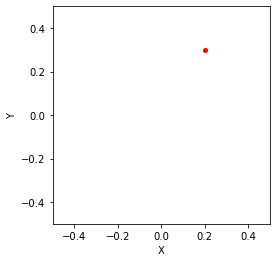

In [3]:
sim.plot2D()

### Running the simulation

To run the simulation — to actually time-evolve Maxwell's equations — you call `sim.run`.   
* Meep supports many ways to decide when to stop the simulation, and many analyses you can execute *while* the simulation is running, but the simplest thing is just to run for a fixed amount of time.
* Here, we run until `t=8`.  Since our optical period is `0.4`, this corresponds to 20 optical periods.

Afterwards, we will call `plot2D` again, but this time we will plot the $H_z$ field.

FloatProgress(value=0.0, description='0% done ', max=8.0)

run 0 finished at t = 8.0 (1600 timesteps)


<AxesSubplot:xlabel='X', ylabel='Y'>

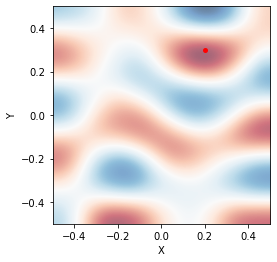

In [4]:
sim.run(until=8)
sim.plot2D(fields=mp.Hz)

We can also call `sim.get_array` to fetch a Numpy array containing the fields (in the whole cell or any subregion), and perform whatever analyses or plotting that we want:

(0.0, 99.0, 0.0, 99.0)

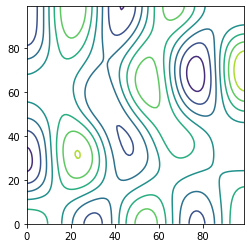

In [5]:
plt.contour(sim.get_array(component=mp.Hz))
plt.axis("square")

(Beware that Matplotlib's coordinate system is "sideways" from what you might expect.  The first axis of the array in Meep corresponds to the $x$ coordinate, but Matplotlib's `contour` function plots that as the "vertical" axis.)

### Animation 

Since this is a time-domain simulation, it is nice to actually *see* the time dependence by *animating* the fields.

You can do this manually by exporting the fields, plotting them, and forming the animation yourself, but Meep includes [an `Animate2D` object type](https://meep.readthedocs.io/en/latest/Python_User_Interface/#animate2d) that collects the data for you.   You pass it to `run` wrapped in an `at_every` function, which tells Meep how often you want to collect animation frames.

-----------
Initializing structure...
time for choose_chunkdivision = 8.10623e-06 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
time for set_epsilon = 0.0174699 s
-----------


FloatProgress(value=0.0, description='0% done ', max=5.0)

Normalizing field data...
run 1 finished at t = 5.0 (1000 timesteps)


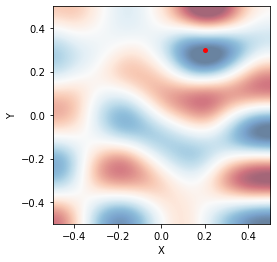

In [6]:
sim.reset_meep() # restart the simulation at t=0
animate = mp.Animate2D(sim, fields=mp.Hz, normalize=True)
sim.run(mp.at_every(0.4/10,animate),until=5)

When the simulation is done, you call `animate.to_mp4` to output an MP4 video file, and you can then use IPython's `Video` function to make the video visible in the notebook:

In [7]:
filename = "square-cavity1.mp4"
fps = 10
animate.to_mp4(fps,filename)
Video(filename)

Generating MP4...


## Exciting resonant modes

Of course, the square metallic cavity is very, very special because its eigenmodes (from which every Maxwell solution can be obtained) can be found analytically.  In particular, we saw in class that the eigenmodes for the $H_z$ polarization in an $L\times L$ cavity are:

$$
H_z^{(n_x, n_y)} = \cos(n_x \pi x/L) \cos(n_y \pi y/L)
$$
with corresponding eigenfrequencies
$$
\omega_{(n_x, n_y)} = \frac{\pi}{L} \sqrt{n_x^2 + n_y^2}
$$

Here, since $L=1$ and $c=1$, these correspond to vacuum wavelengths $\lambda = 2\pi c / \omega = 2 / \sqrt{n_x^2 + n_y^2}$, or frequencies $f = \sqrt{n_x^2 + n_y^2} / 2$.  For example, the $n_x = n_y = 1$ solution corresponds to $f = \sqrt{1^2 + 1^2}/2 = \sqrt{1/2}$.   Since this solution is non-degenerate, if we put in a *narrow-bandwidth pulse* centered on that frequency, that mode should be (nearly) the only one excited.  Let's see it!

-----------
Initializing structure...
time for choose_chunkdivision = 8.82149e-06 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
time for set_epsilon = 0.014514 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 497.04/1000.0 = 49.7% done in 4.0s, 4.0s to go
on time step 99590 (time=497.95), 4.01649e-05 s/step
run 0 finished at t = 1000.0 (200000 timesteps)


<AxesSubplot:xlabel='X', ylabel='Y'>

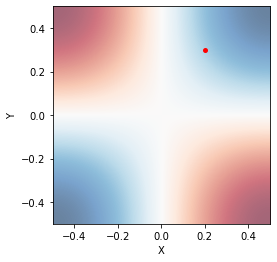

In [8]:
# this time, a Gaussian pulse:
sources_r = [mp.Source(mp.GaussianSource(frequency=np.sqrt(1+1)/2, fwidth=0.01),
                                         component=mp.Hz,
                                         center=(0.2,0.3))]

sim_r = mp.Simulation(cell_size=(1,1),  # square 1x1 computational cell
                      sources=sources_r,
                      resolution=100)   # 100 pixels per distance unit

sim_r.run(until_after_sources=0) # run until after the pulse has turned off
sim_r.plot2D(fields=mp.Hz)

## Two sources: Mirror symmetry

One of the key consequences of symmetry that we will derive is that the **irrep is conserved**:  if the sources and/or initial fields are partner functions of an irreducible representation (irrep) of the symmetry group, then the fields at *all future times* will be partners of that irrep.

For example, this computational cell has a horizontal mirror symmetry plane at $x=0$, and the irreps of this (taken by itself) correspond to *symmetric* and *anti-symmetric* functions.   So, if we put in a **symmetric source** then **the resulting fields will be symmetric**, and similarly for anti-symmetric.

As a technical matter, since the magnetic field is a [pseudovector](https://en.wikipedia.org/wiki/Pseudovector), a symmetric $H_z$ (or magnetic current) pattern "looks anti-symmetric".   We will use the `amplitude` property of the source to make two magnetic point sources at $(0.2,0.3)$ and $(-0.2,0.3)$ with opposite signs, and animate the resulting fields.

-----------
Initializing structure...
time for choose_chunkdivision = 5.96046e-06 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
time for set_epsilon = 0.0163379 s
-----------


FloatProgress(value=0.0, description='0% done ', max=5.0)

Normalizing field data...
run 0 finished at t = 5.0 (1000 timesteps)


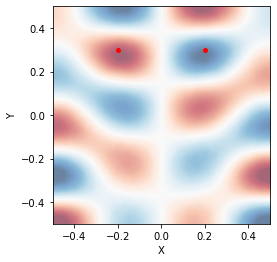

In [9]:
sources2 = [mp.Source(mp.ContinuousSource(wavelength=0.4, width=4),
                                          component=mp.Hz,
                                          center=(0.2,0.3),
                                          amplitude=1.0),
            mp.Source(mp.ContinuousSource(wavelength=0.4, width=4),
                                          component=mp.Hz,
                                          center=(-0.2,0.3),
                                          amplitude=-1.0)]

sim2 = mp.Simulation(cell_size=(1,1),
                     sources=sources2,
                     resolution=100)


animate2 = mp.Animate2D(sim2, fields=mp.Hz, normalize=True)
sim2.run(mp.at_every(0.4/10,animate2),until=5)

In [10]:
filename = "square-cavity2.mp4"
animate2.to_mp4(10,filename)
Video(filename)

Generating MP4...


Of course, a square cavity has much more than just mirror symmetry!   It's symmetry group is technically the [C4v group](http://symmetry.jacobs-university.de/cgi-bin/group.cgi?group=404&option=4), and has 5 possible irreps that we can excite.

For example, if we put sources at the corners $(\pm 0.3, \pm 0.3)$ of a $0.6\times 0.6$ square, and adjust the amplitude so that **rotating by 90° multiplies by i**, then it turns out we excite a partner of the **2d irrep**, and the resulting fields have a sort of *conserved "discrete" angular momentum*.

-----------
Initializing structure...
time for choose_chunkdivision = 6.91414e-06 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
time for set_epsilon = 0.0175002 s
-----------


FloatProgress(value=0.0, description='0% done ', max=10.0)

Normalizing field data...
run 0 finished at t = 10.0 (2000 timesteps)


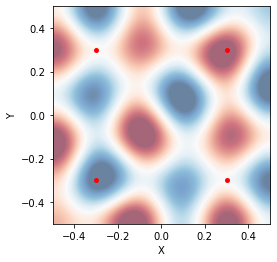

In [11]:
λ = 0.4
sources4 = [mp.Source(mp.ContinuousSource(wavelength=λ, width=0.2),
                                          component=mp.Hz,
                                          center=(0.3,0.3),
                                          amplitude=1.0),
            mp.Source(mp.ContinuousSource(wavelength=λ, width=0.2),
                                          component=mp.Hz,
                                          center=(-0.3,0.3),
                                          amplitude=1.0j),
            mp.Source(mp.ContinuousSource(wavelength=λ, width=0.2),
                                          component=mp.Hz,
                                          center=(-0.3,-0.3),
                                          amplitude=-1.0),
            mp.Source(mp.ContinuousSource(wavelength=λ, width=0.2),
                                          component=mp.Hz,
                                          center=(0.3,-0.3),
                                          amplitude=-1.0j),]

sim4 = mp.Simulation(cell_size=(1,1),
                     sources=sources4,
                     resolution=100)

animate4 = mp.Animate2D(sim4, fields=mp.Hz, normalize=True)
sim4.run(mp.at_every(λ/10,animate4),until=10)

In [12]:
filename = "square-cavity4.mp4"
animate4.to_mp4(10,filename)
Video(filename)

Generating MP4...


## Changing the materials

In all of the examples above, the cavity was filled by the default material, *vacuum* (ε=μ=1).   Most systems of interest in nanophotonics have some non-trivial arrangement of dielectric materials, however.  Meep supports [lots of kinds of electromagnetic materials](https://meep.readthedocs.io/en/latest/Materials/), in fact (e.g. dielectric, magnetic, anistropic, dispersive, nonlinear, …)!

In Meep, you can specify material arrangements in various ways, but the most common is by specifying a `geometry` parameter to the `Simulation` object.  `geometry` is a list of ["geometric objects"](https://meep.readthedocs.io/en/latest/Python_User_Interface/#geometricobject) (blocks, cylinders, polygons, etcetera), each of which has a [material](https://meep.readthedocs.io/en/latest/Python_User_Interface/#medium).

Here, let's add a single object — a dielectric cylinder with ε=4 (refractive index 2, i.e. halved spatial wavelength) — in the center, which preserves the symmetry but completely changes the solutions!

-----------
Initializing structure...
time for choose_chunkdivision = 3.79086e-05 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
     cylinder, center = (0,0,0)
          radius 0.25, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (4,4,4)
time for set_epsilon = 0.0693309 s
-----------


FloatProgress(value=0.0, description='0% done ', max=10.0)

Normalizing field data...
run 0 finished at t = 10.0 (2000 timesteps)


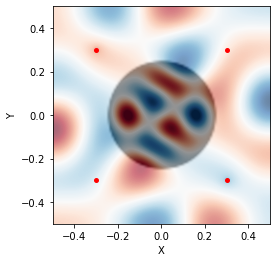

In [13]:
geometry = [mp.Cylinder(radius=0.25,
                        center=(0,0),
                        material=mp.Medium(epsilon=4))]

sim4c = mp.Simulation(cell_size=(1,1),
                      geometry=geometry,
                      sources=sources4,
                      resolution=100)

animate4c = mp.Animate2D(sim4c, fields=mp.Hz, normalize=True)
sim4c.run(mp.at_every(λ/10,animate4c),until=10)

In [14]:
filename = "square-cavity4c.mp4"
animate4c.to_mp4(10,filename)
Video(filename)

Generating MP4...
